# 0.0 Table of Contents

1. [Introduction](#1.0-Introduction)

2. [Feature Analysis](#2.0-Feature-Analysis)

3. [Modeling](#3.0-Modeling)


# 1.0 Introduction
 

### 1.1 Project -  Binary classification of bitcoin addresses

-  **GOAL:** to predict whether an address has been the recipient of ransomware coins. 

-  **DATA:**  Data is time series (24hr chunks) derived from the topological and geometrical properties of the bitcoin network.

### 1.2 Basics

- Ransomware is a rogue compute code that encrypts the victim's filesystem unless money is paid to the attacker for decryption. 

- Bitcoin is often used for these payments because it provides a semi-anonymous transaction method.  Classify bitcoin addressess as 

- The dataset was taken from the UCI Machine Learning Repository. It contains labelled data of addresses according to whether they have been involved in Ransomware. The data is from 2009 January to 2018 December. 
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

#### 1.2.0 Information:
---
**"starter transactions"**: transactions which are spent outputs from the  previous time window <n>

features:

- The **address** is a public address (key) which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC)
<b>
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses:
<b>
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction
has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
address is an output address of a starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from any starter
transaction and ending at address $a$. he count feature represents
information on the number of transactions, whereas the weight
feature represents information on the amount (what percent of
these transactions’ output?) of transactions.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain). 
    
       
<n>
Engineered/derived features:
    
- bc_income
    
- bc_length
    
- yeo_weight
   
- logbc_n_addres

- bc_neighbors
   
- sig_looped
   
- log_count
   
- day_of_week
    
 <n>
     
 **Datatypes and content of master variables**
     
     - X_df : all features [dataframe]
     - X : all features [ndarray]
     - X_train : training data inc. engineered features [dataframe]
     - labels : binary 1=ransom, 0=white [ndarray]
     - X_train_ss : scaled (standard scalarized features: mean=0,var=1) [ndarray]
     - X_train_tree : unscaled features [ndarray]
     - y_test : labels [ndarray]
     - negative_df : downsampled features from negative class [dataframe] 
     - positive_df : downsampled features from positve class [dataframe]
     - combined_X : appended downsampled standardized features from both classes [dataframe]
    

### 1.3 Packages and helper functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import pickle
import pdb
import datetime
import warnings

from scipy import stats
from scipy.stats import randint
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE


from scipy.stats import pearsonr
from scipy.stats import boxcox, yeojohnson

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from prettytable import PrettyTable
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
DS_FRAC = .25

### 1.4 Importing saved data

In [3]:
NF = 5 

In [4]:
fname = 'X_train_y_train_X_test_y_test_0'+str(NF)+'.pickle'

In [5]:
Xy = pd.read_pickle(fname)
Xy_d = pd.read_pickle('derived'+fname)
Xy_e = pd.read_pickle('encoded'+fname)

In [6]:
for i in [0,1,2,3]:
    Xy[i].reset_index(drop=True,inplace=True)
    Xy_d[i].reset_index(drop=True,inplace=True)
    #Xy_e[i].reset_index(drop=True,inplace=True)


In [7]:
# Test/train split of unmodified data 
X_train = Xy[0]
y_train = Xy[1]
X_test  = Xy[2]
y_test  = Xy[3]

In [8]:
X_train

,address,year,day,length,weight,count,looped,neighbors,income
0,1CufFHv2P9PKbY7Vark4htZJcmwFQD8BSo,2018,272,2,1.000000e+00,1,0,2,6.110000e+07
1,13PSV222kAeKeHhZz1bJKh2q4YKSPhPxUD,2011,5,42,6.103516e-05,1,0,2,1.970000e+09
2,367RfLy8PBSpvuEKjY3X3X9iWt4RMwdsKy,2018,287,2,1.000000e+00,1,0,1,5.663199e+07
3,15eCeGrYDYF1WACHrbUgy71rrFH3tksG1V,2014,336,2,5.555556e-02,1,0,1,1.600000e+08
4,19xhezoeCdRfkArdQpXHxJEVxmJTpPk7FF,2016,78,0,5.000000e-01,1,0,2,5.000000e+07
...,...,...,...,...,...,...,...,...,...
2245851,19bRohpkgkHxvYpJE11LogQ3miLfjYfmn8,2011,103,58,7.450581e-09,1,0,2,6.207267e+10
2245852,17Cp5fhJ3Mriz8KtbVrn4SdM5ak4jJD2Dc,2015,106,16,6.250000e-02,1,0,2,1.430162e+08
2245853,15tMc1UW3gVpVJDmfzkpkNhsmyT69iELnC,2017,146,0,5.000000e-01,1,0,2,4.009917e+08
2245854,1AgiezDcp2Nb94Na5MaqSPmkM6P54b6D5C,2013,219,0,7.722008e-04,1,0,1,5.000000e+07


In [9]:
X_train.drop(labels=['address'],axis=1,inplace=True)
X_test.drop(labels=['address'],axis=1,inplace=True)
X_train_ns = X_train.to_numpy() # not std. transformed
X_test_ns  = X_test.to_numpy()  # not std. transformed

In [10]:
# Test/train split of transformed data (engineered to reduce skew)
X_train_d = Xy_d[0]
y_train_d = Xy_d[1]
X_test_d  = Xy_d[2]
y_test_d  = Xy_d[3]

In [11]:
X_train_d.drop(labels=['address'],axis=1,inplace=True)
X_test_d.drop(labels=['address'],axis=1,inplace=True)

In [12]:
# Test/train split of transformed, std. normalized, and encoded data
# numpy arrays. Has standard scalarizing and encoding. for X column names are gone and address is dropped.
X_train_e = Xy_e[0] 
y_train_e = Xy_e[1] # labels
X_test_e  = Xy_e[2]
y_test_e  = Xy_e[3] # labels

In [13]:
X_train_e.shape

(2245856, 22)

In [46]:
colnames = ['year',
 'day',
 'length',
 'weight',
 'count',
 'looped',
 'neighbors',
 'income',
 'bc_income',
 'bc_length',
 'yeo_weight',
 'logbc_n_address',
 'bc_neighbors',
 'sig_looped',
 'log_count',
  'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# make data frame
X_train_e_df = pd.DataFrame(X_train_e, columns=colnames)
X_test_e_df = pd.DataFrame(X_test_e, columns=colnames)
print('X_train_e has been standardized to zero mean and unit variance')
X_train_e_df['looped'].mean(), X_train_e_df['looped'].var()
           

X_train_e has been standardized to zero mean and unit variance


(-2.2295261401004454e-17, 1.00000044526472)

In [15]:
y_train.reset_index(drop=True,inplace=True)

In [16]:
y_test.value_counts()

labels
0.0       661316
1.0         9525
dtype: int64

In [17]:
y_test_e.value_counts()

labels
0.0       661316
1.0         9525
dtype: int64

In [18]:
y_test_e.reset_index(drop=True,inplace=True)

In [19]:
y_test_e == y_test

,labels
0,True
1,True
2,True
3,True
4,True
...,...
670836,True
670837,True
670838,True
670839,True


# 2.0 Standardizing,  Splitting, and Downsampling

In [20]:
print('Training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_train['labels']),
    len(y_train['labels']) - sum(y_train['labels'])
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_train['labels'])/(len(y_train['labels'])) * 100)))

Training set has 2245856 rows and 8 columns.
Testing set has 670841 rows and 8 columns.
Training set has 31888.0 points that belong to postitive class (ransomware) and 2213968.0 points that belong to negative class (white).
Percentage of positive class data-points: 1.42%


## 2.1 Sampling

### 2.1.0 Downsampling 

In [21]:
class Sampler:
    
    def __init__(self,X):
        self.X_df = pd.DataFrame(X)
        self.positive_df = pd.DataFrame([], columns = self.X_df.columns)
        self.negative_df = pd.DataFrame([], columns = self.X_df.columns)
        self.combined_df = pd.DataFrame([], columns = self.X_df.columns) 
        self.X_train_sm =  pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_sm =  pd.DataFrame([], columns = ['lables'])
        self.X_train_rus = pd.DataFrame([], columns = self.X_df.columns)
        self.y_train_rus =  pd.DataFrame([], columns = ['lables'])

        
    
    def up_samp_smote(self, X_train, y_train, ratio):
        """Upsamples minority class using SMOTE.
        Ratio argument is the percentage of the upsampled minority class in relation
        to the majority class. 
        """
        sm = SMOTE(random_state=RAND_STATE, sampling_strategy=ratio)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
        #print(len(X_train_sm), len(y_train_sm))
        self.X_train_sm, self.y_train_sm = X_train_sm, y_train_sm
       
    
    def down_samp_rand(self, X_train, y_train, ratio):
        """Downsamples majority class using random sampling.
        Ratio argument is the ratio of minority class to the downsampled majority 
        """
        rus = RandomUnderSampler(sampling_strategy=ratio,random_state=RAND_STATE) 
        X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
        self.X_train_rus, self.y_train_rus = X_train_rus, y_train_rus
    
    
    def down_samp(self, y_train, prob=0.015):
        index = 0

        for index_df, row in tqdm(self.X_df.iterrows(), total=self.X_df.shape[0]):
            if y_train[index] == 0:
                if np.random.uniform(0, 1) < prob:
                    #picking negative class with a probability=prob
                    self.negative_df = self.negative_df.append(row, ignore_index=True)
                    index += 1
                else:
                    index += 1
            elif y_train[index] == 1:
            #picking all positive data-points
                self.positive_df = self.positive_df.append(row, ignore_index=True)
                index += 1
        self.combined_df = self.positive_df.append(self.negative_df, ignore_index = True)

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [22]:
e_ds = Sampler(X_train_e_df) # sampler constructor 

In [23]:
e_ds.down_samp_rand(X_train_e, y_train_e['labels'], 0.05) # downsample using random resampling

In [24]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.25) # upsampling using SMOTE

In [25]:
y_train.value_counts()

labels
0.0       2213968
1.0         31888
dtype: int64

In [26]:
e_ds.y_train_sm.value_counts()

0.0    637760
1.0    159440
Name: labels, dtype: int64

In [27]:
e_ds.y_train_sm.value_counts(normalize=True)

0.0    0.8
1.0    0.2
Name: labels, dtype: float64

In [272]:
e_ds.down_samp(y_train['labels']) # down sampling

  0%|          | 0/2245856 [00:00<?, ?it/s]

In [273]:
# make new data frames for positive and negative down sampled encoded data
combined_X_e_df = e_ds.combined_df
combined_X_e = combined_X_e_df.to_numpy()
combined_labels = np.append([1] * e_ds.positive_df.shape[0], 
                            [0] * e_ds.negative_df.shape[0])

**ss_ds** <n>
- standard scaled and normalized for distance modeling.
- Split of X_train_ss [standardized, encoded] without column headers.

In [ ]:
#d_ds = Sampler(X_train_d) # sampler constructor 
#d_ds.up_samp_smote(y_train['labels'], .75) # upsampling using SMOTE
#d_ds.down_samp(d_ds.y_train_sm) # down sampling


#combined_X_d_df = d_ds.combined_df
#combined_X_d = combined_X_d_df.to_numpy()

#combined_y_d = np.append(
#    [1] * d_ds.positive_df.shape[0], 
#    [0] * d_ds.negative_df.shape[0]
#)

**class ns_ds** <n>
- for plotting and tree modeling.
- Split of X_train [non-standardized, non-encoded].

In [ ]:
#n_ds = Sampler(X_train_ns) # sampler constructor 
#n_ds.up_samp_smote(y_train['labels'], .75) # upsampling using SMOTE
#n_ds.down_samp(n_ds.y_train_sm) # down sampling

#combined_X_ns_df = n_ds.combined_df
#combined_X_ns = combined_X_ns_df.to_numpy()
#combined_y_ns = np.append([1] * n_ds.positive_df.shape[0], 
#                            [0] * n_ds.negative_df.shape[0])

## 2.2 Visualization and EDA

### 2.2.0 Univariate

In [274]:
def pdf_plot_compare(ft_name):
    sns.distplot(e_ds.negative_df[ft_name], label = 'White')
    sns.distplot(e_ds.positive_df[ft_name], label = 'Ransomware')
    plt.legend()
    plt.title('distribution of ' + ft_name )
    plt.show()

In [275]:
cols_new = X_train_e_df.columns
cols_new=cols_new[:-7]

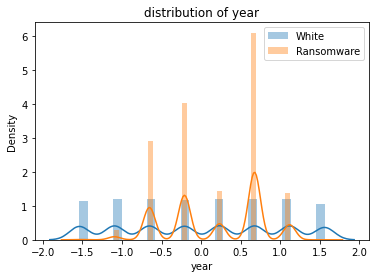

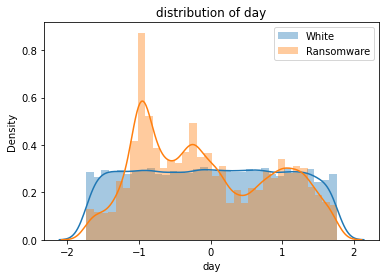

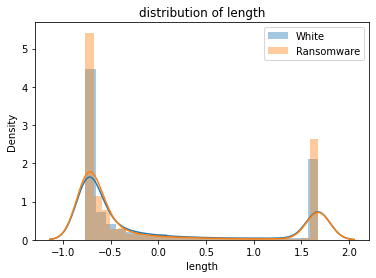

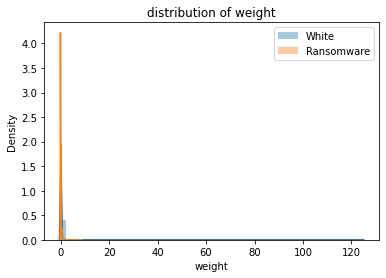

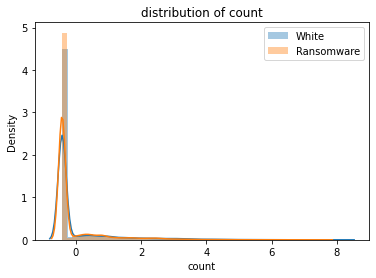

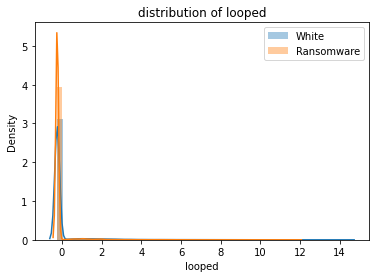

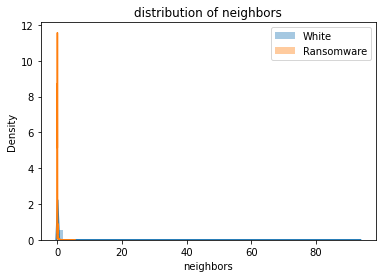

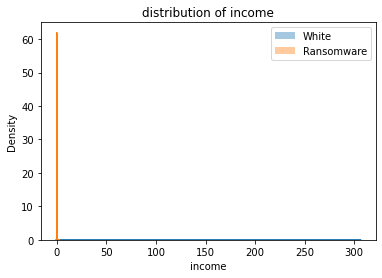

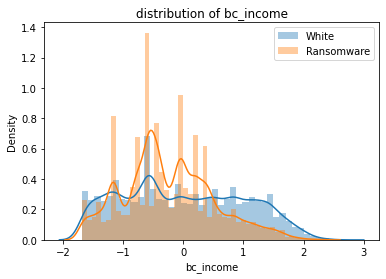

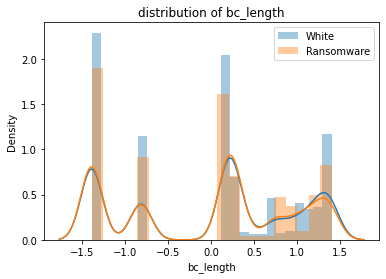

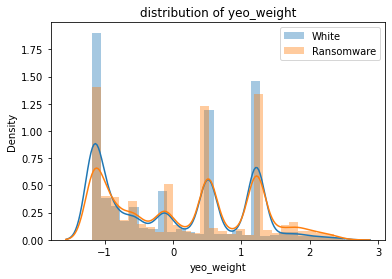

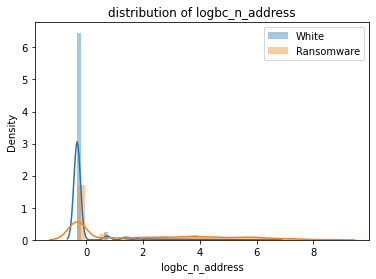

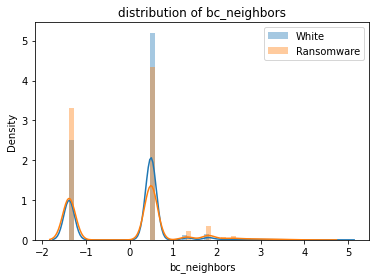

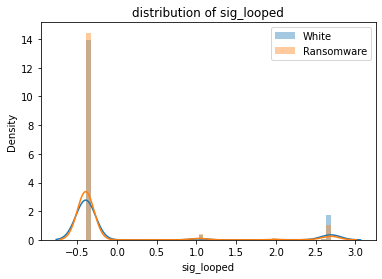

In [276]:
for fts in cols_new:
        pdf_plot_compare(fts)

### 2.2.1 Multivariate

Correlation matrix

In [29]:
n_corr = X_train_e_df.corr()
corr_abs  = n_corr.abs()
upper_triangle =corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > 0.89)]

['count', 'neighbors', 'sig_looped', 'log_count']

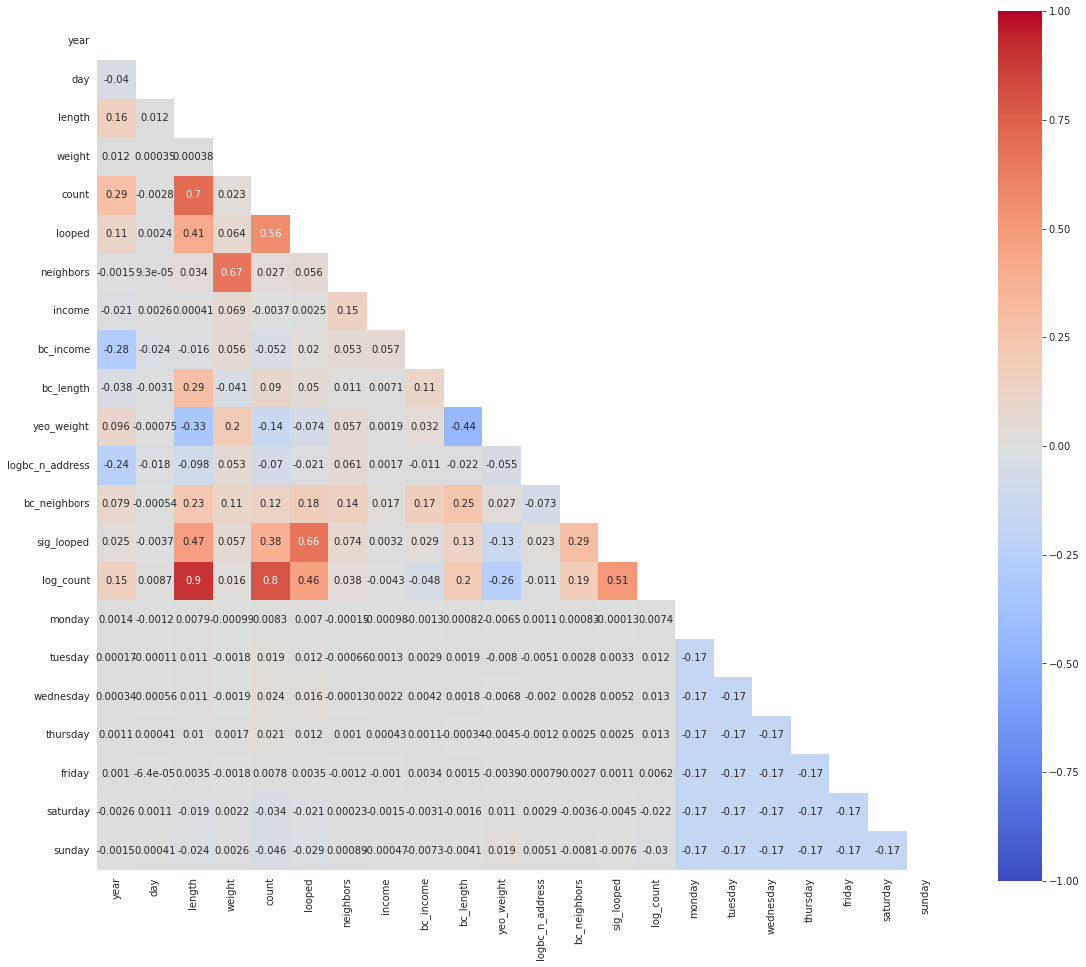

In [30]:
mask = np.zeros_like(n_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(19, 16))
    ax = sns.heatmap(n_corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

Remove highly correlated column

In [43]:
# drop highly correlated column
#
colnames = list(np.delete(colnames,colnames.index('log_count')))

drop_log_cnt = lambda x: x.drop(columns=['log_count'],inplace=True)

combined_X_e_df.drop(columns=['log_count'],inplace=True)
X_train_e_df.drop(columns=['log_count'],inplace=True)
X_test_e_df.drop(columns=['log_count'],inplace=True)
#
# convert to numpy again
#
X_train_e = X_train_e_df.to_numpy()
X_test_e = X_test_e_df.to_numpy()
combined_X_e = combined_X_e_df.to_numpy()

ValueError: 'log_count' is not in list

# 3.0 Modeling

In [32]:
def plot_roc(model,X,y,plot_title):
    plot_roc_curve(model,X,y)
    plt.title(plot_title)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
    plt.legend()
    plt.show()
    
def tabulate_scores_df(model_name, y_test, y_pred):
 
    df2 = pd.DataFrame([[
        model_name,
        accuracy_score(y_true = y_test, y_pred = y_pred),
        precision_score(y_true = y_test, y_pred = y_pred),
        recall_score(y_true = y_test, y_pred = y_pred),
        f1_score(y_true = y_test, y_pred = y_pred)]],
        columns = ['Model Name','Accuracy','Precision','Recall','F1-Score'])

    return df2
    

Test/train split of (down) sampled 50/50 data 

In [33]:
# Generate a mini (balanced) data-set for hyper-parameter tuning
combined_X_train, combined_X_test, combined_y_train, combined_y_test = train_test_split(
    combined_X_e_df,   # standardard X with  1 = pos/neg class ratio
    combined_labels, # y 
    test_size = SPLIT_RATIO,  
    shuffle = True,
    random_state = RAND_STATE
)

NameError: name 'combined_X_e_df' is not defined

In [34]:
score_names = ['Model Name','Accuracy','Precision','Recall','F1-Score']
scores_df = pd.DataFrame([], columns = score_names)

## 3.1 Stochastic Gradient Descent 

* Models based on the relative spatial distribution of data in the observation space. For these models, the training data must be transformed to zero mean unit variance.

### 3.1.0 SGD Classification

#### 3.1.0.1 Optimization parameters

In [177]:
# Stochastic Gradient Descent classifier 
from sklearn.linear_model import SGDClassifier

In [178]:
# model is stochastic gradient descent classifier
sgd_cl = SGDClassifier(random_state = RAND_STATE, max_iter=3000, learning_rate='optimal')

# parameter search
sgd_params_in = {
    "loss" : [ "log_loss", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet"],
    "class_weight" : ['balanced', None]
}

sgd_hyperparams = RandomizedSearchCV(
    estimator = sgd_cl,
    param_distributions = sgd_params_in,
    scoring = 'recall',
    n_jobs = -1,
    verbose = 1,
    random_state = RAND_STATE,
    return_train_score = True,
    n_iter = 5,
)

#### 3.1.0.2 Modeling with unbalanced sampled data 

In [179]:
# fit the parameters to the encoded data (not downsampled)
sgd_hyperparams.fit(e_ds.X_train_sm, e_ds.y_train_sm)
# get the fitted modeling parameters
sgd_bps = sgd_hyperparams.best_params_
# fit with optimized parameters
sgd_opt = SGDClassifier(**sgd_bps, n_jobs = -1, random_state = RAND_STATE)

# fit 
sgd_opt.fit(e_ds.X_train_sm, e_ds.y_train_sm)
# make predicition
sgd_opt_preds = sgd_opt.predict(e_ds.X_train_sm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [180]:
sgd_opt_preds_train = sgd_opt.predict(X_train_e)  
sgd_opt_preds_test = sgd_opt.predict(X_test_e)  

In [181]:
sgd_trn_score_df = tabulate_scores_df('SGD_trn', y_train_e, sgd_opt_preds_train )
sgd_tst_score_df = tabulate_scores_df('SGD_tst', y_test_e, sgd_opt_preds_test)
sgd_scores_df = sgd_trn_score_df.append(sgd_tst_score_df)


In [182]:
sgd_scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score
0,SGD_trn,0.676956,0.025152,0.576079,0.048199
0,SGD_tst,0.683702,0.025466,0.570919,0.048758


In [183]:
scores_df = scores_df.append(sgd_scores_df)
scores_df.reset_index(drop=True,inplace=True)

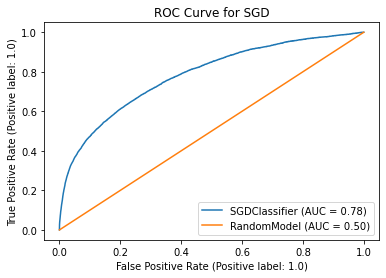

In [356]:
plot_roc(sgd_opt,X_test_e,y_test_e['labels'], 'ROC Curve for SGD')

#### 3.1.0.3 Modeling  balanced sampled data

In [235]:
sgd_hyperparams_down = sgd_hyperparams.fit(combined_X_train, combined_y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [236]:
len(combined_X_test.columns) == len(combined_X_train.columns)

True

In [237]:
# get the fitted modeling parameters
sgd_down_bps = sgd_hyperparams_down.best_params_
#  model with optimized parameters
sgd_opt_down = SGDClassifier(**sgd_down_bps,n_jobs = -1, random_state = RAND_STATE)
# fit the downsampled data
sgd_opt_down.fit(combined_X_train, combined_y_train)
# prediction for down sampled data
sgd_opt_down_preds = sgd_opt_down.predict(combined_X_test) 
# prediction based on full data with params tuned from downsampled data
sgd_opt_preds_test = sgd_opt_down.predict(X_test_e)  


In [238]:
sgd1_score_df = tabulate_scores_df('SGD_down', combined_y_test, sgd_opt_down_preds)
sgd2_score_df = tabulate_scores_df('SGD_1', y_test, sgd_opt_preds_test)
scores_df = sgd0_score_df.append(sgd2_score_df) #.append(sgd2_score_df)
scores_df.reset_index(drop=True,inplace=True)
scores_df

,Model Name,Accuracy,F1-Score,Precision,Recall
0,SGD_0,0.711052,0.470674,0.338769,0.770791
1,SGD_1,0.947025,0.187443,0.119815,0.430341


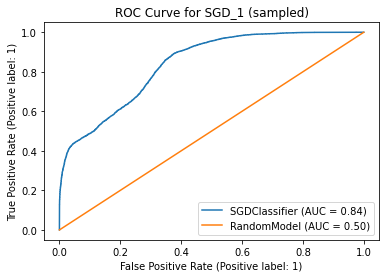

In [234]:
plot_roc(sgd_opt_down,combined_X_test,combined_y_test, 'ROC Curve for SGD_1 (sampled)')

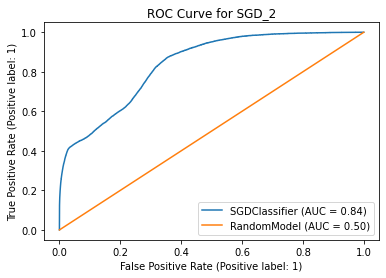

In [59]:
plot_roc(sgd_opt_down, X_test_e,y_test_e, 'ROC Curve for SGD_2')

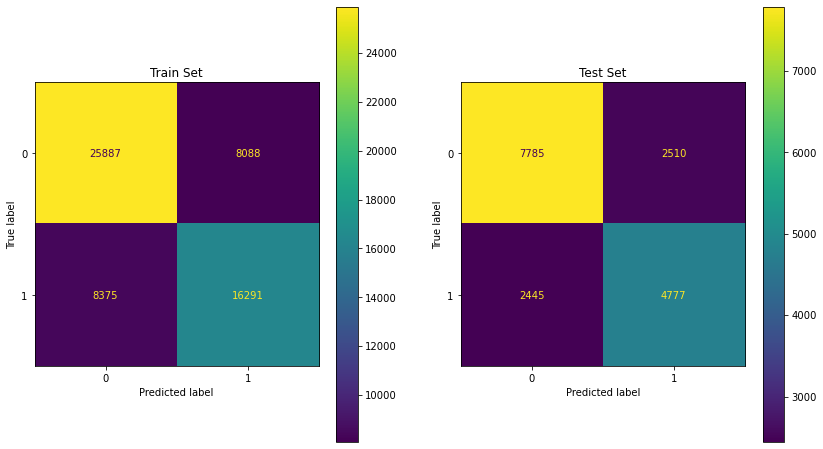

In [45]:
# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(14,8))

plot_confusion_matrix(sgd_opt_down,combined_X_train,combined_y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(sgd_opt_down,combined_X_test,combined_y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

In [239]:
print(classification_report(combined_y_test, sgd_opt_down_preds))
print(classification_report(y_test_e, sgd_opt_preds_test))
print(classification_report(y_train_e, sgd_opt_preds_train))

              precision    recall  f1-score   support

           0       0.71      0.95      0.81     10295
           1       0.85      0.44      0.58      7222

    accuracy                           0.74     17517
   macro avg       0.78      0.69      0.70     17517
weighted avg       0.77      0.74      0.72     17517

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    661316
         1.0       0.12      0.43      0.19      9525

    accuracy                           0.95    670841
   macro avg       0.56      0.69      0.58    670841
weighted avg       0.98      0.95      0.96    670841

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82   2213968
         1.0       0.04      0.77      0.07     31888

    accuracy                           0.70   2245856
   macro avg       0.52      0.73      0.44   2245856
weighted avg       0.98      0.70      0.81   2245856



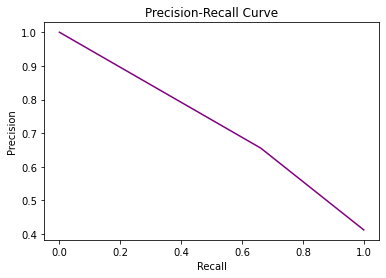

In [47]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(combined_y_test, sgd_opt_down_preds)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
#display plot
plt.show()

## 3.2 Decision Trees

### 3.2.0 Random Forest Classification

#### 3.2.0.1 Parameters

In [142]:
# parameter search
rf_params_in = {
    'max_depth' : [2,5,10,15],
    'n_estimators' : [100, 500, 1000],
    "class_weight" : ['balanced', None]
}

rf_clf = RandomForestClassifier(n_jobs = -1,random_state = RAND_STATE)

# used randomized search to look for optimal parameters
rf_hyperparams = RandomizedSearchCV(
    estimator = rf_clf, 
    param_distributions = rf_params_in,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    random_state = RAND_STATE,
    return_train_score = True,
    n_iter = 5
)

####  3.2.0.1 RF model with HP tuning on resampled data

In [36]:
rf_hyperparams.fit(e_ds.X_train_sm, e_ds.y_train_sm) # fit to get optimal parameters 
rf_bps = rf_hyperparams.best_params_
# save results
#
# remodel with optimized parameters
rf_opt_down = RandomForestClassifier(
    **rf_bps,   # pass optimal parameters 
    n_jobs = -1,               
    random_state = RAND_STATE)
#
# fit 
rf_opt_down.fit(e_ds.X_train_sm, e_ds.y_train_sm) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [161]:
pd.DataFrame([rf_hyperparams.best_params_]).to_csv('rf_bestparams_sm_e_05.csv')

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [58]:
rf_opt_down.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [53]:
# predict 
rf_opt_preds = rf_opt_down.predict(e_ds.X_train_sm) # prediction from downsampled train
rf_opt_preds_train = rf_opt_down.predict(X_train_e) # prediction from train
rf_opt_preds_test = rf_opt_down.predict(X_test_e)   # prediction from test

In [59]:
rf_opt_down_feat_ranks_df = pd.DataFrame(np.ravel(rf_opt_down.feature_importances_), index=colnames)
rf_opt_down_feat_ranks_df.columns = ['feature importance']
rf_opt_down_feat_ranks_df.sort_values(by='feature importance', ascending=False).head(5)

,feature importance
year,0.313469
logbc_n_address,0.288787
bc_income,0.090060
income,0.067281
day,0.051200


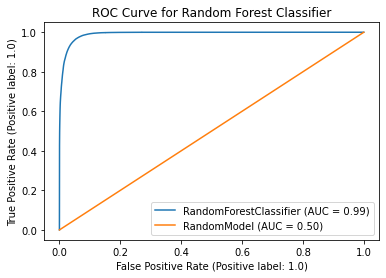

In [60]:
plot_roc(rf_opt_down,e_ds.X_train_sm, e_ds.y_train_sm, 'ROC Curve for Random Forest Classifier')

In [61]:
print(classification_report(y_train, rf_opt_preds_train))
print(classification_report(y_test, rf_opt_preds_test))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97   2213968
         1.0       0.19      0.95      0.31     31888

    accuracy                           0.94   2245856
   macro avg       0.59      0.94      0.64   2245856
weighted avg       0.99      0.94      0.96   2245856

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95    661316
         1.0       0.12      0.91      0.21      9525

    accuracy                           0.90    670841
   macro avg       0.56      0.91      0.58    670841
weighted avg       0.99      0.90      0.94    670841



In [64]:
rf_trn_score_df = tabulate_scores_df('RF_trn', y_train, rf_opt_preds_train)
rf_tst_score_df = tabulate_scores_df('RF_tst', y_test, rf_opt_preds_test)

In [79]:
rf_scores_df = rf_trn_score_df.append(rf_tst_score_df)
rf_scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_trn,0.940706,0.186698,0.946312,0.311868
0,RF_tst,0.902312,0.118172,0.909921,0.209179


<AxesSubplot:>

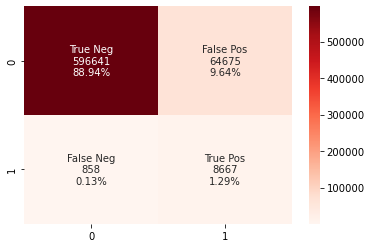

In [80]:
# confusion matrix
cf_matrix = confusion_matrix(y_test, rf_opt_preds_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Reds')

#####  Compare scores

In [81]:
scores_df = scores_df.append(rf_scores_df) #.append(rf1_score_df)
scores_df.reset_index(drop=True,inplace=True)
scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_trn,0.940706,0.186698,0.946312,0.311868
1,RF_tst,0.902312,0.118172,0.909921,0.209179


### 3.2.1 Xtreme Gradient Boosted Decision Tree (XGBT) Classification

In [82]:
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

####  3.2.1.1 Optimization Parameters

In [117]:
# we use counter to decide how much weight to give the positive class (ransom address labels)
# because only 1.5% of our data-set contains positive datapoints
counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

kf = KFold(n_splits=5,shuffle = True, random_state = RAND_STATE)

# basic classifier constructor [for parameter search] 
xgb_clf = XGBClassifier(
    objective = 'binary:logistic', 
    use_label_encoder=False,
    #scale_pos_weight = estimate,  
    random_state = RAND_STATE,
)


param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'scale_pos_weight' : stats.uniform(estimate,estimate**2),
              'min_child_weight': [1, 2, 3, 4]
             }
xgb_hyperparams = RandomizedSearchCV(
    xgb_clf, 
    param_distributions = param_dist,
    cv = kf,  
    n_iter = 4, 
    scoring = 'recall', 
    error_score = 0, 
    verbose = 0, 
    n_jobs = -1
)

#### 3.2.1.2 xGBDT with tuning

In [114]:
for col in colnames[-7:]:
    X_train_e_df[col]=X_train_e_df[col].astype(np.int32)
X_train_e = X_train_e_df.to_numpy()

In [138]:
y_train_np = np.ravel(y_train['labels'].to_numpy()).astype(np.int32)
y_train_np[4546] == y_train.loc[[4546]]

0

In [141]:
# fit the encoded, unbalanced data using scale_pos_weight to account for the unbalancedness
xgb_hyperparams.fit(X_train_e, y_train_np)  # pass conditioned np arrays

/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA

[12:51:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:02:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:21] WARNING: /Users/runner/miniforge3/cond

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16c47c070>,
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16c46e910>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16c4efee0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x16c50a2e0>},
                   scoring='recall')

In [154]:
xgb_hyperparams.best_params_

{'colsample_bytree': 0.6034871321612655,
 'learning_rate': 0.3956881259343352,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 552,
 'scale_pos_weight': 76.87869855035574,
 'subsample': 0.8716548844406891,
 'n_jobs': -1,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'random_state': 42}

In [162]:
# save results
pd.DataFrame([xgb_hyperparams.best_params_]).to_csv('xgb_bestparams_train_e_05.csv')

In [144]:
params_xgb = xgb_hyperparams.best_params_
params_xgb['n_jobs'] = -1 
params_xgb['booster'] = 'gbtree'
params_xgb['objective'] = 'binary:logistic'
params_xgb['random_state'] = RAND_STATE
#params_xgb['scale_pos_weight'] = estimate
params_xgb

{'colsample_bytree': 0.6034871321612655,
 'learning_rate': 0.3956881259343352,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 552,
 'scale_pos_weight': 76.87869855035574,
 'subsample': 0.8716548844406891,
 'n_jobs': -1,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'random_state': 42}

In [145]:
# rerun classifier with optimized parameters
xgb_clf_opt = XGBClassifier(**params_xgb).fit(X_train_e_df, y_train['labels'], verbose=1)

[14:53:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:24] WARNING: /Users/runner/miniforge3/cond

{'colsample_bytree': 0.8410545220556309,
 'learning_rate': 0.5618069757979138,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 769,
 'subsample': 0.7332006072135541,
 'n_jobs': -1,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'random_state': 42,
 'scale_pos_weight': 69.42950326141495}

In [146]:
xgb_opt_preds_test = xgb_clf_opt.predict(X_test_e)
xgb_opt_preds_train = xgb_clf_opt.predict(X_train_e)

<AxesSubplot:>

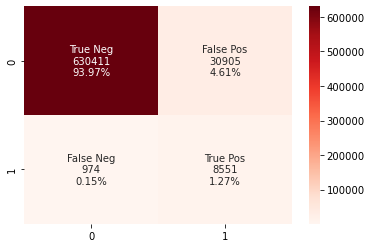

In [155]:
# confusion matrix for test data
cf_matrix = confusion_matrix(y_test, xgb_opt_preds_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Reds')

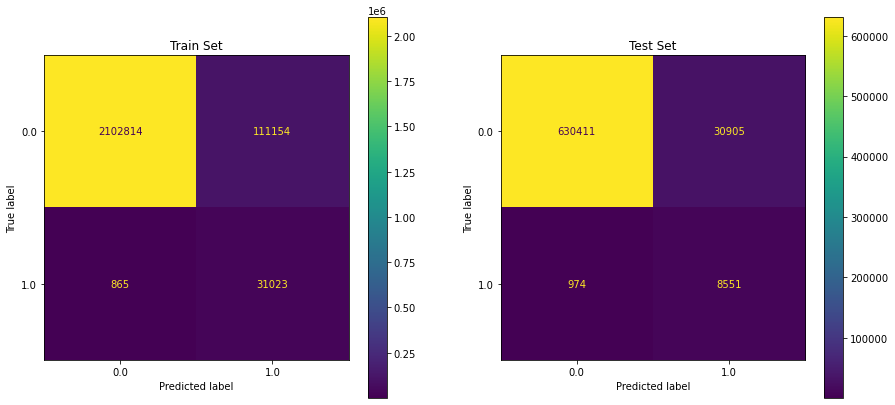

In [156]:
# plot confusion matrices for test and train
fig, ax = plt.subplots(1,2, figsize=(15,7))

plot_confusion_matrix(xgb_clf_opt, X_train_e,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(xgb_clf_opt, X_test_e,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

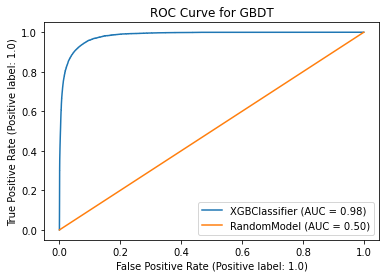

In [157]:
plot_roc(xgb_clf_opt, X_test_e, y_test,'ROC Curve for GBDT') 

In [158]:
xgb_trn_score_df = tabulate_scores_df('XGBDT_trn', y_train, xgb_opt_preds_train)
xgb_tst_score_df = tabulate_scores_df('XGBDT_tst', y_test, xgb_opt_preds_test)

In [159]:
xgb_scores_df = xgb_trn_score_df.append(xgb_tst_score_df)
xgb_scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBDT_trn,0.950122,0.218200,0.972874,0.356453
0,XGBDT_tst,0.952479,0.216722,0.897743,0.349156


,Model Name,Accuracy,F1-Score,Precision,Recall
0,SGD_0,0.734630,0.070634,0.037165,0.710236
1,SGD_1,0.734351,0.070836,0.037269,0.713176
2,RF_1,0.952634,0.337676,0.210663,0.850394
3,XGBDT_1,0.795087,0.108419,0.057779,0.877480


####  Original data no tuning

In [163]:
# Original data
# X_train is not processed.

counter = Counter(y_train['labels'])
estimate = np.sqrt(counter[0] / counter[1])

xbg_clf0 = XGBClassifier(
    n_estimators = 500,
    max_depth = 2,
    verbosity = 1,
    n_jobs = 6,
    random_state = RAND_STATE,
    scale_pos_weight = estimate
).fit(X_train, y_train['labels'], verbose=1)

[15:20:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


NameError: name 'gbdt_orig' is not defined

In [168]:
xgb_preds_train = xbg_clf0.predict(X_train)
xgb_preds_test = xbg_clf0.predict(X_test)

In [170]:
xgb0_trn_score_df = tabulate_scores_df('XGBDT_trn_og', y_train, xgb_preds_train)
xgb0_tst_score_df = tabulate_scores_df('XGBDT_tst_og', y_test, xgb_preds_test)
xgb_scores_df = xgb_scores_df.append(xgb0_trn_score_df).append(xgb0_tst_score_df)

In [171]:
scores_df = scores_df.append(xgb_scores_df)
scores_df.reset_index(drop=True,inplace=True)

## 3.3 Summary of model results

In [243]:
scores_df

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_trn,0.940706,0.186698,0.946312,0.311868
1,RF_tst,0.902312,0.118172,0.909921,0.209179
2,XGBDT_trn,0.950122,0.2182,0.972874,0.356453
3,XGBDT_tst,0.952479,0.216722,0.897743,0.349156
4,XGBDT_trn_og,0.977231,0.313949,0.509251,0.388432
5,XGBDT_tst_og,0.976789,0.306019,0.500682,0.379864
6,SGD_trn,0.676956,0.025152,0.576079,0.048199
7,SGD_tst,0.683702,0.025466,0.570919,0.048758


In [244]:
tst_scores_df = scores_df.iloc[1:9:2]

In [246]:
tst_scores_df.reset_index(drop=True,inplace=True)

In [266]:
np.round(tst_scores_df.iloc[:2],decimals=2)

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_tst,0.902312,0.118172,0.909921,0.209179
1,XGBDT_tst,0.952479,0.216722,0.897743,0.349156


In [271]:
trn_scores_df = scores_df.iloc[0:6:2]
trn_scores_df =trn_scores_df.sort_values(by='Recall',ascending=False)
trn_scores_df.reset_index(drop=True,inplace=True)


In [288]:
trn_scores_df.columns[1:]

Index(['Accuracy', 'Precision', 'Recall', 'F1-Score'], dtype='object')

In [234]:
tst_scores_df=tst_scores_df.sort_values(by='Recall',ascending=False)
tst_scores_df.reset_index(drop=True).iloc[0:-1]

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_tst,0.902312,0.118172,0.909921,0.209179
1,XGBDT_tst,0.952479,0.216722,0.897743,0.349156
2,SGD_tst,0.683702,0.025466,0.570919,0.048758


In [291]:
cast_cols = trn_scores_df.columns[1:]
for c in cast_cols:
    tst_scores_df[c] = tst_scores_df[c].astype(float).round(3)
    trn_scores_df[c] = trn_scores_df[c].astype(float).round(3)

/var/folders/lj/my6r3k650wl54v5nz5r6x5cm0000gn/T/ipykernel_44028/2597407325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tst_scores_df[c] = tst_scores_df[c].astype(float).round(3)


In [295]:
tst_scores_df[0:2]

,Model Name,Accuracy,Precision,Recall,F1-Score
0,RF_tst,0.902,0.118,0.910,0.209
1,XGBDT_tst,0.952,0.217,0.898,0.349


In [185]:
scores_df.to_csv('all_model_rank_scores.csv')

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#sns.barplot(data=scores_df, x='Model Name', y='Accuracy', ax=axes[0,0])
#sns.barplot(data=scores_df, x='Model Name', y='Precision', ax=axes[0])
#sns.barplot(data=scores_df, x='Model Name', y='Recall', ax=axes[1])
#sns.barplot(data=scores_df, x='Model Name', y='F1-Score', ax=axes[2])
#plt.title("Model Comparisons")
#plt.savefig('model_metrics_ bars.png',dpi=400)

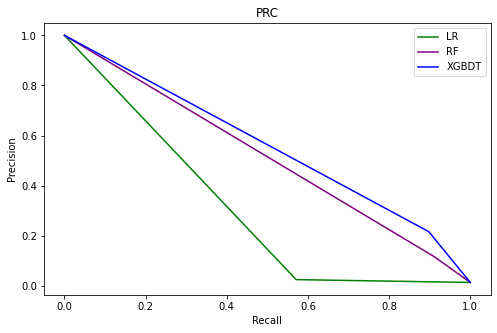

In [237]:
#calculate precision and recall

#create precision recall curve
fig, ax = plt.subplots(figsize=(8,5))
precision, recall, thresholds = precision_recall_curve(y_test, sgd_opt_preds_test)
ax.plot(recall, precision, color='green', label = 'LR' )
#add axis labels to plot
ax.set_title('PRC')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
precision, recall, thresholds = precision_recall_curve(y_test, rf_opt_preds_test)
ax.plot(recall, precision, color='purple', label  = 'RF')
#add axis labels to plot
#display plot
precision, recall, thresholds = precision_recall_curve(y_test, xgb_opt_preds_test)
ax.plot(recall, precision, color='blue', label  = 'XGBDT')
plt.legend(loc='upper right')
#add axis labels to plot
#display plot
plt.savefig('PRC.png',dpi=400)


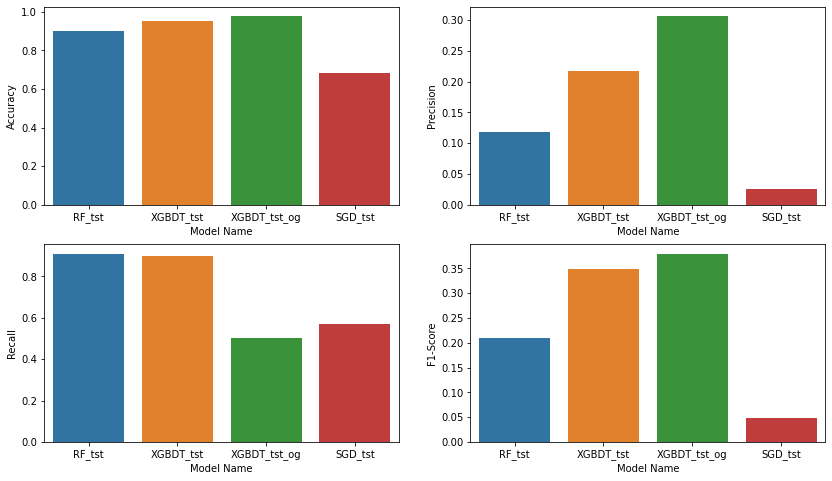

In [273]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
sns.barplot(data=tst_scores_df, x='Model Name', y='Accuracy', ax=axes[0,0])
sns.barplot(data=tst_scores_df, x='Model Name', y='Precision', ax=axes[0,1])
sns.barplot(data=tst_scores_df, x='Model Name', y='Recall', ax=axes[1,0])
sns.barplot(data=tst_scores_df, x='Model Name', y='F1-Score', ax=axes[1,1])
#plt.title("Model Comparisons")
plt.savefig('bars.png',dpi=400)